In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import xgboost as xgb
#from keras.models import Model
#from keras.layers import Input, Dense

from evaluation import model_evaluation, backtest

In [98]:
# Load the data
stats = pd.read_csv('data/PlayersStats_1971-2024.csv')
shares = pd.read_csv('data/SharesMIP_1986-2024.csv')

# Merge stats and shares
data = stats.merge(shares, how = 'left', on = ['href', 'Year'], suffixes = ['', '_y']).drop(columns = ['Player_y'])
data = data.fillna(0.)
data = data.reset_index(drop = True)

start_year = 1991

In [99]:
# For each entry, determine the lifetime of the player career, its career high in points, assists, rebounds and minutes played
def player_history(df) :
    df = df.sort_values('Year') # Sort by year
    df['lifetime'] = [len(df[df['Year'] <= yr]) for yr in df['Year']]
    pts_high, ast_high, trb_high, mp_high, prev_yr = [], [], [], [], []
    for yr in df['Year']:
        df_prev = df[df['Year'] < yr]
        pts_high.append(df_prev['PTS'].max())
        ast_high.append(df_prev['AST'].max())
        trb_high.append(df_prev['TRB'].max())
        mp_high.append(df_prev['MP'].max())
        prev_yr.append(df_prev['Year'].astype(int).max())
    df['PTS_high'] = pts_high
    df['AST_high'] = ast_high
    df['TRB_high'] = trb_high
    df['MP_high']  = mp_high
    df['prevYear'] = prev_yr
    return df

data = data.groupby('href', group_keys = False).apply(player_history)

In [100]:
data = data.merge(stats.rename(columns = {'Year': 'prevYear'}), on = ['href', 'prevYear'], suffixes = ['', '_prev'], how = 'inner')

In [101]:
# Calculate the difference in stats for all numerical features
features =  ['G','GS','MP','FG','FGA','FG%','3P','3PA','3P%','2P','2PA','2P%','eFG%','FT','FTA','FT%','ORB','DRB','TRB','AST',
             'STL','BLK','TOV','PF','PTS','PER','TS%','3PAr','FTr','ORB%','DRB%','TRB%','AST%','STL%','BLK%','TOV%','USG%',
             'OWS','DWS','WS','WS/48','OBPM','DBPM','BPM','VORP','W','L','W/L%','SRS','Seed','MOV','ORtg','DRtg','NRtg']

for f in features :
    data[f'{f}_diff'] = data[f] - data[f'{f}_prev']
data['PTS_rel'] = [(pts - prev) / prev if prev > 0 else 0 for pts, prev in zip(data['PTS'], data['PTS_prev'])]

In [102]:
# Requirements (minutes and game)
data = data[(data['MP'] >= 10) | (data['Share'] > 0)]     # Minimum 10 minutes played
data = data[(data['MP_prev'] >= 5) | (data['Share'] > 0)] # Minimum 5 minutes played in previous season
data = data[(data['G'] >= 15) | (data['Share'] > 0)]      # Minimum 20 games played
data = data[(data['G_prev'] >= 10) | (data['Share'] > 0)] # Minimum 10 games played in previous season

# Eligibility
data = data[(data['PTS'] > 0.9 * data['PTS_high']) | (data['Share'] > 0)] # Points within 90% of career high
data = data[(data['AST'] >= data['AST_high']) | (data['TRB'] >= data['TRB_high']) | (data['MP'] >= data['MP_high']) | (data['Share'] > 0)] # At least a career high in minutes, assists or rebounds

In [103]:
data = data[data['Year'] >= 1986].reset_index(drop = True)

In [107]:
features = ['PTS','FG','VORP','FGA','OWS','WS','MP','PER','TRB','AST','OBPM','USG%']
features = [f + '_diff' for f in features] + ['PTS_rel','lifetime']

In [108]:
# 1. Linear Regression
lr = LinearRegression()

# 2. Random Forest
rf = RandomForestRegressor(n_estimators = 250, max_depth = 12)

# 3. XGBoost
xg = xgb.XGBRegressor(n_estimators = 150, learning_rate = 0.2)

# 4. Neural Network
#nn = create_nn([64, 32, 16])

In [109]:
# Run backtests
backtest_lr = backtest(start_year, data.copy(), lr, features)
backtest_rf = backtest(start_year, data.copy(), rf, features)
backtest_xg = backtest(start_year, data.copy(), xg, features)
#backtest_nn = backtest(start_year, data_norm.copy(), nn, features, keras = (10, 32))

[1/34] ... 1991 ...   
[2/34] ... 1992 ...   
[3/34] ... 1993 ...   
[4/34] ... 1994 ...   
[5/34] ... 1995 ...   
[6/34] ... 1996 ...   
[7/34] ... 1997 ...   
[8/34] ... 1998 ...   
[9/34] ... 1999 ...   
[10/34] ... 2000 ...   
[11/34] ... 2001 ...   
[12/34] ... 2002 ...   
[13/34] ... 2003 ...   
[14/34] ... 2004 ...   
[15/34] ... 2005 ...   
[16/34] ... 2006 ...   
[17/34] ... 2007 ...   
[18/34] ... 2008 ...   
[19/34] ... 2009 ...   
[20/34] ... 2010 ...   
[21/34] ... 2011 ...   
[22/34] ... 2012 ...   
[23/34] ... 2013 ...   
[24/34] ... 2014 ...   
[25/34] ... 2015 ...   
[26/34] ... 2016 ...   
[27/34] ... 2017 ...   
[28/34] ... 2018 ...   
[29/34] ... 2019 ...   
[30/34] ... 2020 ...   
[31/34] ... 2021 ...   
[32/34] ... 2022 ...   
[33/34] ... 2023 ...   
[34/34] ... 2024 ...   
[1/34] ... 1991 ...   
[2/34] ... 1992 ...   
[3/34] ... 1993 ...   
[4/34] ... 1994 ...   
[5/34] ... 1995 ...   
[6/34] ... 1996 ...   
[7/34] ... 1997 ...   
[8/34] ... 1998 ...   
[9/34] ..

Linear Reg. :  41.2%
Random Forest :  23.5%
XGBoost :  23.5%


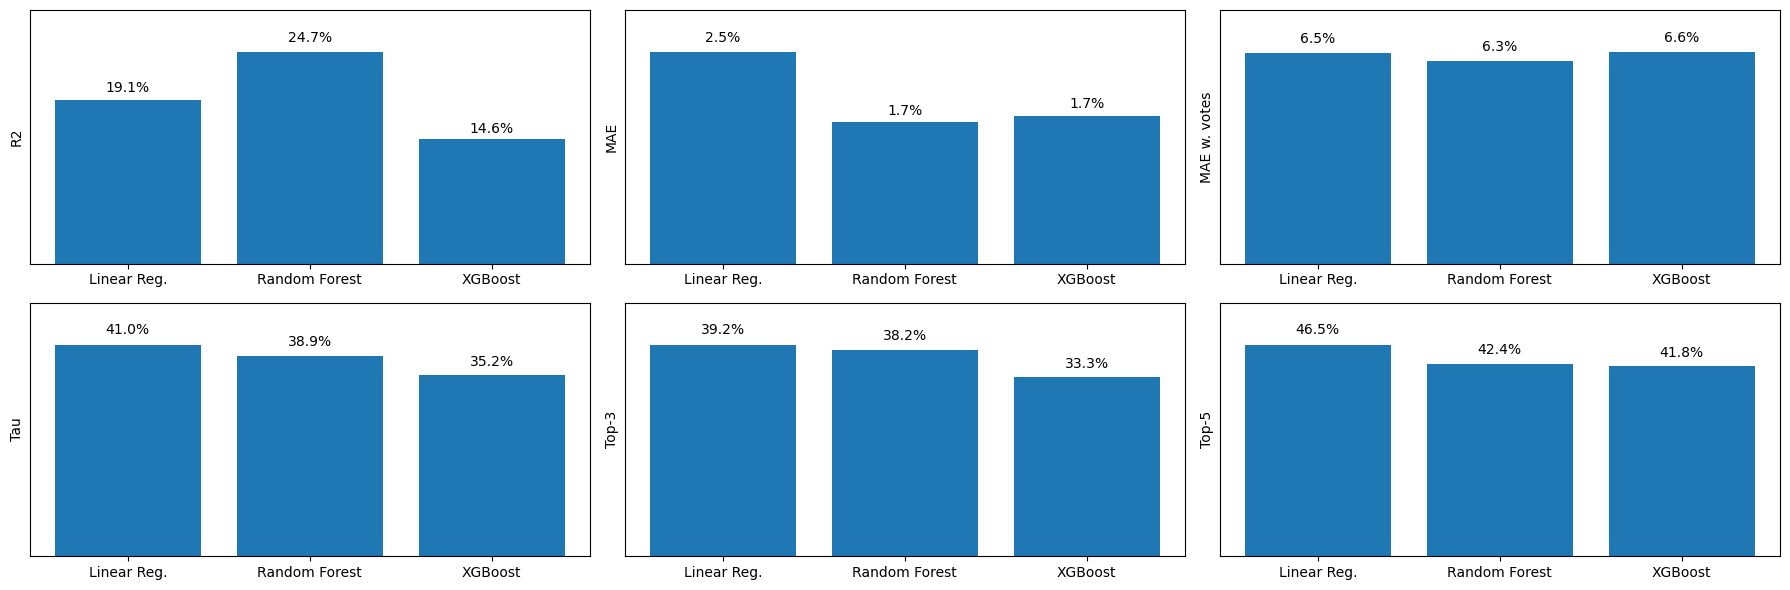

In [110]:
_, axs = plt.subplots(2, 3, figsize = (18, 6)); axs = axs.flatten()

for name, bt in zip(['Linear Reg.', 'Random Forest', 'XGBoost'], [backtest_lr, backtest_rf, backtest_xg]) :
    acc = round(100*bt['Correct'].mean(), 1)
    print(f'{name} :  {acc}%')

for ax, metric in zip(axs, backtest_lr.columns[-6:]) :

    ax.bar(['Linear Reg.', 'Random Forest', 'XGBoost'],
           [bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg]])
    
    for i, (name, bt) in enumerate(zip(['Linear Reg.', 'Random Forest', 'XGBoost'], [backtest_lr, backtest_rf, backtest_xg])) :
        ax.text(i, 1.05 * bt[metric].mean(),  str(round(100 * bt[metric].mean(), 1)) + '%', ha = 'center')

    
    ax.set_ylabel(metric)
    ax.set_ylim([0, 1.2 * max([bt[metric].mean() for bt in [backtest_lr, backtest_rf, backtest_xg]])])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [112]:
backtest_rf

,Winner,Pred. share,Pred. rank,Pred. winner,Share,Rank,Correct,R2,MAE,MAE w. votes,Tau,Top-3,Top-5
Year,,,,,,,,,,,,,
1991,Scott Skiles,0.151033,3,Tim Hardaway,0.063,5,False,0.384380,0.013495,0.049195,0.576352,0.666667,1.0
1992,Pervis Ellison,0.135812,2,Dražen Petrović,0.229,2,False,0.473270,0.010832,0.051947,0.572078,0.666667,0.6
1993,Mahmoud Abdul-Rauf,0.056164,4,Eric Murdock,0.143,2,False,0.366001,0.010203,0.047624,0.486192,0.666667,0.6
1994,Don MacLean,0.173784,2,David Robinson,0.000,-1,False,0.226233,0.017973,0.063799,0.284268,0.333333,0.2
1995,Dana Barros,0.170092,1,Dana Barros,0.476,1,True,0.520027,0.013091,0.045873,0.538860,1.000000,0.8
1996,Gheorghe Mureșan,0.025953,9,Tracy Murray,0.035,5,False,0.012932,0.014412,0.059879,0.273686,0.333333,0.6
1997,Isaac Austin,0.022391,14,Kendall Gill,0.061,5,False,0.028697,0.015384,0.057430,0.287354,0.000000,0.4
1998,Alan Henderson,0.034088,6,Michael Finley,0.052,5,False,0.139266,0.014158,0.055676,0.350797,0.000000,0.2
1999,Darrell Armstrong,0.049480,1,Darrell Armstrong,0.458,1,True,0.183002,0.015348,0.050054,0.180151,0.333333,0.2
